In [24]:
# Numerical Operations
import math
import numpy as np
import random
from pyDOE import lhs
import time

# Reading/Writing Data
import pandas as pd
import os
import scipy.io

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
      
# Post
import matplotlib.pyplot as plt

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [26]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

same_seed(6666)

In [27]:
import torch.nn as nn
import torch.nn.init as init
from collections import OrderedDict

class My_Model(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(My_Model, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))] # Input

        layers.append(('input_activation', act())) # Activation

        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))) # Hidden Layer
            layers.append(('activation_%d' % i, act())) # Activation for Hidden Layer

        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [28]:
h = 0.1  # 0.05是Saving model with loss 0.0354756461...   0.1是Saving model with loss 0.0129727954...
k = 0.1

x = torch.arange(-1, 1 + h, h)
t = torch.arange(0, 1 + k, k)

# 构建所有可能的空间（x）和时间（t）组合的二维网格
X = torch.stack(torch.meshgrid(x, t, indexing='ij')).reshape(2, -1).T

# 边界和初始条件数据
bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # 边界条件为 𝑥=−1（即 x[0]），所有 t 值均相同。
bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T # 𝑥=1（即 x[-1]）处的边界条件，具有 t 的所有值。
ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # 初始条件为 t=0（即 t[0]），所有 x 的值均相同。

X_train = torch.cat([bc1, bc2, ic])

# 边界和初始条件值
y_bc1 = torch.zeros(len(bc1))
y_bc2 = torch.zeros(len(bc2))
y_ic = -torch.sin(math.pi * ic[:, 0])

y_train = torch.cat([y_bc1, y_bc2, y_ic])
y_train = y_train.unsqueeze(1)

X = X.to(device) # 计算域点
X_train = X_train.to(device) # 边界点
y_train = y_train.to(device) # 边界条件值
X.requires_grad = True # 计算域点需要计算导数

criterion = torch.nn.MSELoss() # 损失计算方法

In [29]:
def pde_loss(XT, model): # 改了求导训练就变好了

    u = model(XT)

    u_XT = torch.autograd.grad(u, XT, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = u_XT[:, 0]
    u_t = u_XT[:, 1]

    u_xx = torch.autograd.grad(u_XT, XT, torch.ones_like(u_XT), retain_graph=True, create_graph=True)[0][:, 0]

    loss = criterion(u_t + u.squeeze()*u_x, 0.01 / math.pi * u_xx)
    return loss

def boundary_loss(X_train, y_train, model):

    y_pred = model(X_train)
    total_loss = criterion(y_pred, y_train)

    return total_loss

In [30]:
loss_pde1 = []
loss_bd_ic1 = []

def train(model):

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    optimizer_adam = torch.optim.Adam(model.parameters())

    n_epochs, best_loss, early_stop_count = 1000, math.inf, 0

    for epoch in range(n_epochs):
        optimizer_adam.zero_grad()

        loss_pde = pde_loss(X, model)
        loss_bd_ic = boundary_loss(X_train, y_train, model)
        loss = loss_pde + loss_bd_ic
        loss.backward()
        optimizer_adam.step()


        loss_pde1.append(loss_pde.detach().item())
        loss_bd_ic1.append(loss_bd_ic.detach().item())

        if (epoch+1) % 100 == 0:
            #print(epoch+1, loss.item())
            print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {(loss_pde1[-1]+loss_bd_ic1[-1]):.10f}, loss_pde: {loss_pde1[-1]:.10f}, loss_bd_ic:{loss_bd_ic1[-1]:.10f}') 
            print('Saving model with loss {:.10f}...'.format(best_loss))
            
        if (loss_pde1[-1]+loss_bd_ic1[-1]) < best_loss:
            best_loss = (loss_pde1[-1]+loss_bd_ic1[-1])
            torch.save(model.state_dict(), './models/model.ckpt') # Save your best model
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= 2000: 
            print('\nModel is not improving, so we halt the training session.')
            break

In [31]:
model = My_Model(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
train(model)     # 

Epoch [100/1000]: Train loss: 0.1897586079, loss_pde: 0.0022825242, loss_bd_ic:0.1874760836
Saving model with loss 0.1899400288...
Epoch [200/1000]: Train loss: 0.1010592598, loss_pde: 0.0296753291, loss_bd_ic:0.0713839307
Saving model with loss 0.1013495997...
Epoch [300/1000]: Train loss: 0.0838224068, loss_pde: 0.0234995335, loss_bd_ic:0.0603228733
Saving model with loss 0.0839998554...
Epoch [400/1000]: Train loss: 0.0701410584, loss_pde: 0.0195799172, loss_bd_ic:0.0505611412
Saving model with loss 0.0702311285...
Epoch [500/1000]: Train loss: 0.0628879685, loss_pde: 0.0179164130, loss_bd_ic:0.0449715555
Saving model with loss 0.0629070867...
Epoch [600/1000]: Train loss: 0.0464736512, loss_pde: 0.0147683835, loss_bd_ic:0.0317052677
Saving model with loss 0.0463138372...
Epoch [700/1000]: Train loss: 0.0314774057, loss_pde: 0.0126138134, loss_bd_ic:0.0188635923
Saving model with loss 0.0295293899...
Epoch [800/1000]: Train loss: 0.0206229128, loss_pde: 0.0090476032, loss_bd_ic:0.01

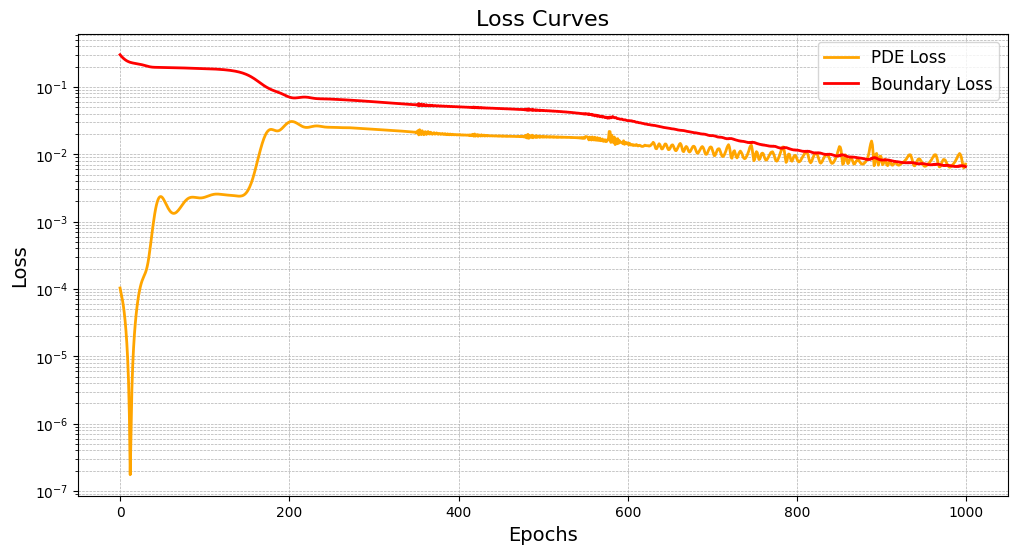

In [32]:
def plot_loss_curves(loss_pde_record, loss_bd_record, save_path='loss_curves.png'):
    plt.figure(figsize=(12, 6))

    # 计算 epoch 范围
    epochs = range(len(loss_pde_record))

    # 绘制各个损失曲线
    #plt.plot(epochs, loss_pde_record + loss_bd_record, label='Total Loss', color='blue', linewidth=2)
    plt.plot(epochs, loss_pde_record, label='PDE Loss', color='orange', linewidth=2)
    plt.plot(epochs, loss_bd_record, label='Boundary Loss', color='red', linewidth=2)

    # 添加标题和标签
    plt.title('Loss Curves', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    # 设置 y 轴的对数刻度（可选）
    plt.yscale('log')

    # 添加网格
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    # 添加图例
    plt.legend(fontsize=12)

    # 保存图像到指定路径
    #plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_loss_curves(loss_pde1, loss_bd_ic1)

In [33]:
model = My_Model(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
model.load_state_dict(torch.load('models/model.ckpt', map_location=device))

model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h).to(device)  # 将 x 移动到设备
t = torch.arange(0, 1, k).to(device)    # 将 t 移动到设备

# 构建网格
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)  # 确保 X 也在设备上

with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()  # 预测并将结果移回 CPU

C:\Users\FAVE\AppData\Local\Temp\ipykernel_27988\3210884036.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model.ckpt', map_loc

In [34]:
plt.figure(figsize=(5, 3), dpi=3000)

plt.imshow(y_pred, aspect='auto', extent=[t.min().item(), t.max().item(), x.min().item(), x.max().item()], cmap='rainbow', origin='lower')
plt.colorbar()  # 添加颜色条
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Prediction of u(t, x)')
plt.show()